In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision
from torchvision import models
from collections import OrderedDict
import torch.nn.init as init
import torch.nn.functional as F
import numpy as np

In [2]:
res18 =  models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [3]:
res18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
class AttentionStem(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, m=4, bias=False):
        super(AttentionStem, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.m = m

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.emb_a = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_b = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_mix = nn.Parameter(torch.randn(m, out_channels // groups), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias) for _ in range(m)])

        self.reset_parameters()
    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])

        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = torch.stack([self.value_conv[_](padded_x) for _ in range(self.m)], dim=0)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(3, self.kernel_size, self.stride).unfold(4, self.kernel_size, self.stride)

        k_out = k_out[:, :, :height, :width, :, :]
        v_out = v_out[:, :, :, :height, :width, :, :]

        emb_logit_a = torch.einsum('mc,ca->ma', self.emb_mix, self.emb_a)
        emb_logit_b = torch.einsum('mc,cb->mb', self.emb_mix, self.emb_b)
        emb = emb_logit_a.unsqueeze(2) + emb_logit_b.unsqueeze(1)
        emb = F.softmax(emb.view(self.m, -1), dim=0).view(self.m, 1, 1, 1, 1, self.kernel_size, self.kernel_size)

        v_out = emb * v_out

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(self.m, batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = torch.sum(v_out, dim=0).view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk->bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')
        for _ in self.value_conv:
            init.kaiming_normal_(_.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.emb_a, 0, 1)
        init.normal_(self.emb_b, 0, 1)
        init.normal_(self.emb_mix, 0, 1)

In [5]:
class CustomModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.preliminary_layer = nn.Sequential(
            OrderedDict([
                ('conv1', model.conv1),
                ('bn1', model.bn1),
                ('relu', model.relu),
                ('maxpool', model.maxpool)
            ])
        ) #3 -> 64
        
        self.layer1 = model.layer1 #64 -> 64
        #attention layer1 64 ->64
        self.layer2 = model.layer2 #64 -> 128
        #attention layer 2 128 ->128
        self.layer3 = model.layer3 #128 -> 256
        #attention layer 256 ->256
        self.layer4 = model.layer4 #256 -> 512
        #attention layer 256 ->512
        self.avg_pool = model.avgpool #512 -> 512 (batch_nu, 512, 1, 1)
        
      
        self.attn1 = AttentionStem(in_channels=64,out_channels=64,kernel_size=4,stride=1,padding=2)
        self.attn2 = AttentionStem(in_channels = 128, out_channels=128,kernel_size=4,stride=1,padding=2)
        self.attn3 = AttentionStem(in_channels=256, out_channels=256,kernel_size=4,stride=1,padding=2)
        self.attn4 = AttentionStem(in_channels=512, out_channels=512,kernel_size=4,stride=1,padding=2)

        self.fc = nn.Sequential(nn.Linear(512, 256), nn.Linear(256, 128), nn.Linear(128, 64) , nn.Linear(64, 10))
    
    def forward(self, x):
        p_layer = self.preliminary_layer(x)
        layer1 = self.layer1(p_layer)
        attn_layer1 = self.attn1(layer1)
        layer2 = self.layer2(attn_layer1)
        attn_layer2 = self.attn2(layer2)
        layer3 = self.layer3(attn_layer2)
        attn_layer3 = self.attn3(layer3)
        layer4 = self.layer4(layer3)
        attn_layer4 = self.attn4(layer4)
        avg = self.avg_pool(attn_layer4).squeeze(3).squeeze(2)
        
        #print(avg.shape)

        lin = self.fc(avg)
        return lin


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
m = CustomModel(models.resnet18(pretrained=True)).to(device)

In [8]:
x = torch.randn(4, 3, 128, 128).to(device)

In [9]:
m(x)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[ 0.0050, -0.0271,  0.1061,  0.0697,  0.0390,  0.0012,  0.1192, -0.0021,
         -0.1331,  0.0303],
        [-0.0619, -0.0915,  0.2378,  0.0424, -0.2280,  0.0072,  0.2053,  0.0929,
         -0.1220, -0.0630],
        [ 0.1806, -0.1515,  0.1465,  0.0863, -0.0696,  0.0832,  0.1340, -0.0039,
         -0.0685,  0.0039],
        [ 0.0943,  0.0031,  0.2857,  0.0620, -0.1655,  0.0850,  0.1152,  0.0231,
         -0.0821, -0.0066]], device='cuda:0', grad_fn=<AddmmBackward>)

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ) ] )
batch_size = 4
# 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optim = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)


In [24]:
import torch.nn.functional as F 
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep

max_acc=0
mb = master_bar(range(3))
for epoch in mb:
    #scheduler.step()
    train_loss = 0
    val_loss = 0
    acc = 0.0
    print("Training....")
    m.train()
    
    for batch, labels in progress_bar(trainloader, parent=mb):
        inp,target = batch.to(device),labels.to(device)
        optim.zero_grad()
        output = m.forward(inp)
        
        op = F.softmax(output,dim=1)
        
        final_op = torch.argmax(output,dim=1)
        
        acc += torch.sum(final_op==target).item()/len(target)
        loss = criterion(output,target)
        
        loss.backward()
        optim.step()
        
        train_loss+=(loss.item()/len(batch))
        
        
    
    acc = acc/len(trainloader)
    
    print("Epoch: ",epoch,"Loss: ",train_loss," Accuracy: ",acc)
    
    
    eval_acc = 0

    m.eval()
    print("Validating.....")
    for batch in progress_bar(testloader, parent=mb):
        inp,target = batch[0].to(device),batch[1].to(device)
        op = F.softmax(m.forward(inp))
        final_op = torch.argmax(op,dim=1)
           
    
        eval_acc += np.sum(final_op.detach().cpu().numpy()==target.detach().cpu().numpy())/len(target)
        
    print("Validation accuracy: ",eval_acc/len(testloader))
    
    if eval_acc>max_acc:
        max_acc = eval_acc
        #torch.save(model_ft,"resnet18.pt")
        MODEL_PATH = './res18.pth'
        OPTIM_PATH = './optim.pth'
        torch.save(m.state_dict(), MODEL_PATH)
        torch.save(optim.state_dict(), OPTIM_PATH)

    #print("FOP",final_op)
    #print("TARGET",target)

Training....
Epoch:  0 Loss:  5575.028398603201  Accuracy:  0.35214
Validating.....


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation accuracy:  0.5117
Training....
Epoch:  1 Loss:  4519.702145654708  Accuracy:  0.49358
Validating.....
Validation accuracy:  0.5443
Training....
Epoch:  2 Loss:  4034.0623469688  Accuracy:  0.55624
Validating.....
Validation accuracy:  0.5714


In [25]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0 MB 17.5 MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=4f447b4794e675460f684496bb3b25b82f33b94e8726a47860ec9a2bf97504aa
  Stored in directory: /root/.cache/pip/wheels/06/e7/da/b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam


In [26]:
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


In [37]:
from PIL import Image
# 
'''transform_ = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])'''
pil_img = Image.open("/content/pexels-tanika-3687770.jpg")
pil_img

In [38]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
#0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [39]:
configs = [
           dict(model_type = "resnet", arch=m,layer_name="layer3")
]

In [40]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [41]:
cams[0]

In [42]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


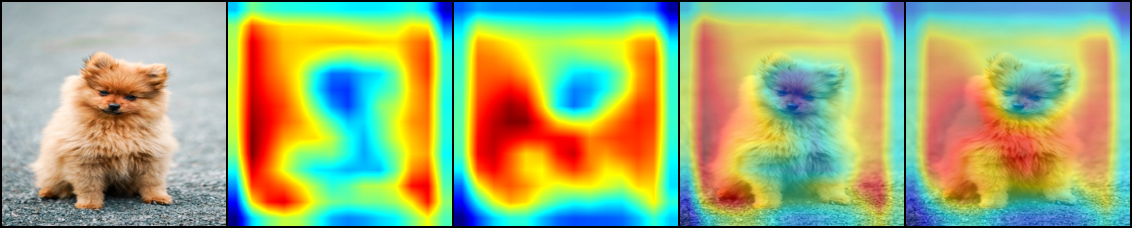

In [43]:
transforms.ToPILImage()(grid_image)